In [1]:
import numpy as np
import pandas as pd

import os.path as op
import numpy as np

from tqdm.contrib.itertools import product
import pingouin
from tms_risk.utils.data import get_subjects, get_all_behavior, get_pdf, get_decoding_info, get_all_apriori_roi_labels, Subject
import seaborn as sns

import matplotlib.pyplot as plt


stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

bids_folder = '/data/ds-tmsrisk/'

# Only TMS target info

In [2]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
# masks = ['NPCr1cm-surface', 'NPCr1cm-cluster', 'NPCr2cm-surface', 'NPCr2cm-cluster']
# n_voxels = [0, 1, 100]
masks = ['NPCr2cm-cluster']
n_voxels = [1]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/105 [00:00<?, ?it/s]

In [3]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels'])[['r']].mean()

In [16]:
r2.groupby(['n_voxels', 'stimulation_condition', 'mask']).size()

n_voxels  stimulation_condition  mask           
1         baseline               NPCr2cm-cluster    35
          ips                    NPCr2cm-cluster    35
          vertex                 NPCr2cm-cluster    35
dtype: int64

In [17]:
pred['Order'] = pred['risky_first'].map({True:'Risky first', False:'Safe first'})

In [18]:
r3_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run', 'Order']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r3 = r3_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'Order'])['r'].mean()

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_99764/2684661393.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r3_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run', 'Order']).apply(lambda d: pingouin.corr(d['E'], d['n1']))


In [19]:
pred['Stimulation condition'] = pred.index.get_level_values('stimulation_condition').map({'vertex': 'Vertex', 'ips': 'IPS', 'baseline':'Baseline'})
pred.set_index('Stimulation condition', append=True, inplace=True)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_99764/2816764074.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 67)` for the same effect.

  g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)


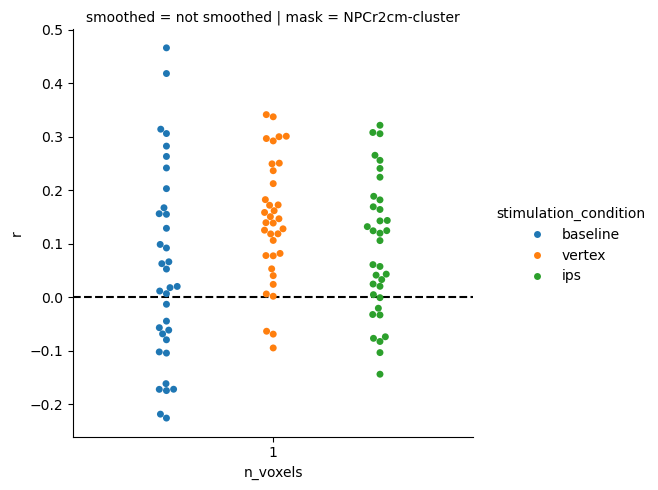

In [20]:
g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_99764/2073728893.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x='stimulation_condition', y='r', data=r2.drop('baseline', level='stimulation_condition').reset_index(), col='n_voxels', kind='point', dodge=True, errorbar='se', palette=['k'], height=6.)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_99764/2073728893.py:3: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  g = sns.catplot(x='stimulation_condition', y='r', data=r2.drop('baseline', level='stimulation_condition').reset_index(), col='n_voxels', kind='point', dodge=True, errorbar='se', palette=['k'], height=6.)


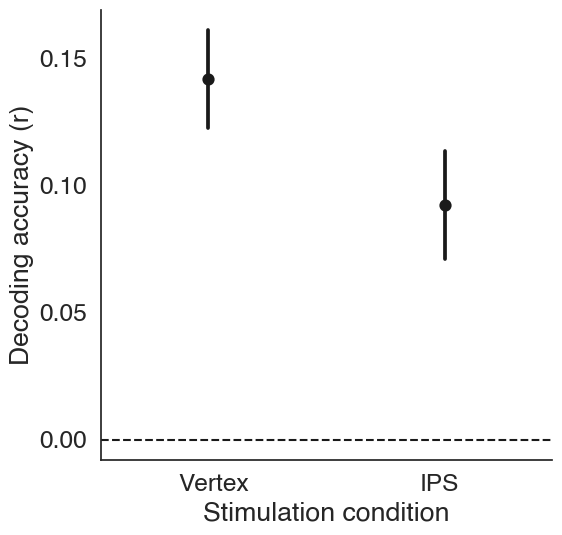

In [32]:
sns.set(font_scale=1.6, style='white', font='Helvetica')

g = sns.catplot(x='stimulation_condition', y='r', data=r2.drop('baseline', level='stimulation_condition').reset_index(), col='n_voxels', kind='point', dodge=True, errorbar='se', palette=['k'], height=6.)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))


g.set(ylabel='Decoding accuracy (r)', xlabel='Stimulation condition')
g.set_xticklabels(['Vertex', 'IPS'])
g.set(yticks=[0.0, 0.05, 0.1, 0.15])
g.set_titles('')

g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'decoding.pdf'))

In [10]:
r2.groupby(['n_voxels', 'stimulation_condition', 'mask']).mean()

r
n_voxels stimulation_condition mask                     
1        baseline              NPCr2cm-cluster  0.053453
         ips                   NPCr2cm-cluster  0.092318
         vertex                NPCr2cm-cluster  0.141897

In [11]:
tmp = r2.drop('baseline', level='stimulation_condition').reset_index()

tmp.groupby(['n_voxels']).apply(lambda d: pingouin.rm_anova(d, 'r', 'stimulation_condition', 'subject'))
# pingouin.rm_anova(tmp, 'r', 'stimulation_condition', 'subject')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_99764/3042827449.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp.groupby(['n_voxels']).apply(lambda d: pingouin.rm_anova(d, 'r', 'stimulation_condition', 'subject'))


,,Source,ddof1,ddof2,F,p-unc,ng2,eps
n_voxels,,,,,,,,
1,0,stimulation_condition,1,34,4.992127,0.032145,0.04188,1.0


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_99764/1369163544.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 67)` for the same effect.

  g = sns.catplot(hue='stimulation_condition', y='r', x='Order', data=r3.drop('baseline', level='stimulation_condition').reset_index(), col='mask', kind='point', dodge=True, ci=67, palette=stimulation_palette)


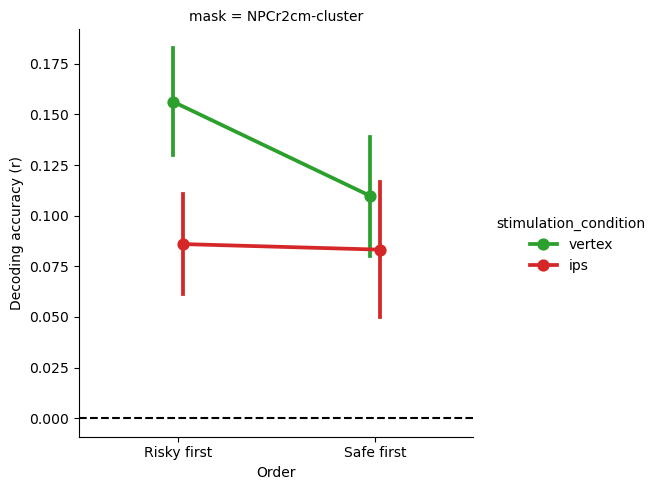

In [12]:
g = sns.catplot(hue='stimulation_condition', y='r', x='Order', data=r3.drop('baseline', level='stimulation_condition').reset_index(), col='mask', kind='point', dodge=True, ci=67, palette=stimulation_palette)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))


g.set(ylabel='Decoding accuracy (r)')




g.savefig(op.join(bids_folder, 'derivatives', 'figures', 'decoding.pdf'))

In [13]:
tmp = r3.drop('baseline', level='stimulation_condition').reset_index()

pingouin.rm_anova(tmp, 'r', ['stimulation_condition', 'Order'], 'subject')

/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/gdehol/mambaforge/envs/tms_risk/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,stimulation_condition,0.082271,1,34,0.082271,2.677735,0.110985,0.110985,0.018626,1.0
1,Order,0.021254,1,34,0.021254,0.794790,0.378922,0.378922,0.004879,1.0
2,stimulation_condition * Order,0.016769,1,34,0.016769,0.861296,0.359918,0.359918,0.003854,1.0


# Get the noise increase for each subject for flexible model

In [ ]:
from tms_risk.cogmodels.fit_model import build_model, get_data

In [66]:
tmp = r2.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').droplevel('session').unstack('stimulation_condition')['r']

pingouin.ttest(tmp['ips'], tmp['vertex'], True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.234307,34,two-sided,0.032145,"[-0.09, -0.0]",0.412123,1.611,0.658698


In [77]:
pred['n_bin'] = pd.cut(pred['n1'], np.arange(5, 100, 5), labels=np.arange(7.5, 97.5, 5))

In [78]:
pred['n_bin_q'] = pd.qcut(pred['n1'], 7)

pred['n_bin_q'] = pred['n_bin_q'].apply(lambda x: x.mid)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94923/3079950012.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'stimulation_condition', 'n_bin']).mean().drop('baseline', level='stimulation_condition')


<Axes: xlabel='n_bin', ylabel='sd'>

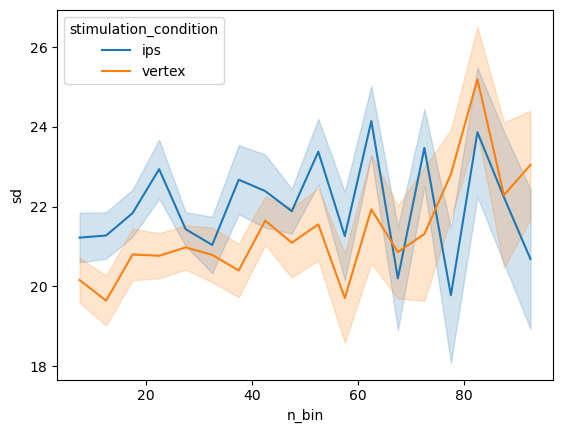

In [79]:
tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'stimulation_condition', 'n_bin']).mean().drop('baseline', level='stimulation_condition')

sns.lineplot(x='n_bin', y='sd', hue='stimulation_condition', data=tmp.reset_index(), errorbar='se')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94923/888137233.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')


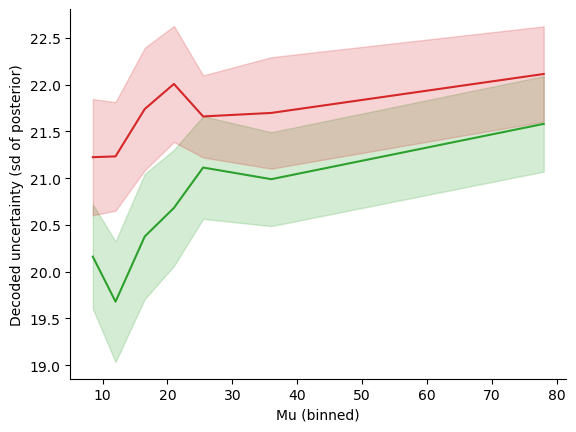

In [116]:
tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')

g = sns.lineplot(x='n_bin_q', y='sd', hue='Stimulation condition', data=tmp.reset_index(), errorbar='se', palette=stimulation_palette, hue_order=stimulation_order, legend=False)

g.set(xlabel='Mu (binned)', ylabel='Decoded uncertainty (sd of posterior)')



# g.add_legend()
sns.despine()

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'decoding_sd.pdf'))
# g.savefig()

In [105]:
pred['error'] = pred['n1'] - pred['E']
pred['abs(error)'] = np.abs(pred['error'])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_94923/962597191.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')


(5.0, 40.0)

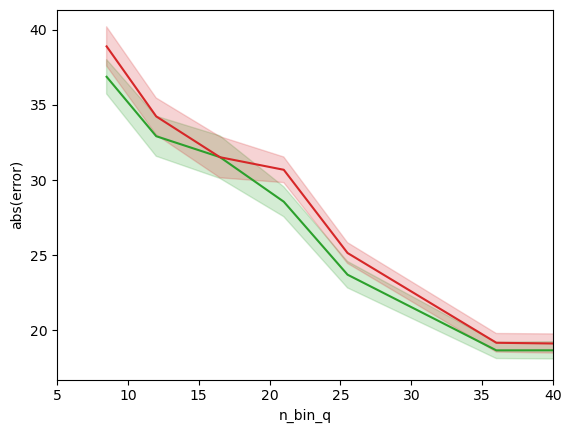

In [110]:
tmp = pred.xs('NPCr2cm-cluster', 0, 'mask').xs(1, 0, 'n_voxels').groupby(['subject', 'Stimulation condition', 'n_bin_q']).mean().drop('Baseline', level='Stimulation condition')

sns.lineplot(x='n_bin_q', y='abs(error)', hue='Stimulation condition', data=tmp.reset_index(), errorbar='se', palette=stimulation_palette, hue_order=stimulation_order, legend=False)

plt.xlim(5, 40)

# 12 a-priori ROIs

In [43]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
# masks = ['NPCr1cm-surface', 'NPCr1cm-cluster', 'NPCr2cm-surface', 'NPCr2cm-cluster']
# n_voxels = [0, 1, 100]
masks = get_all_apriori_roi_labels()
n_voxels = [1]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/1260 [00:00<?, ?it/s]

/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-03/func/sub-03_ses-3_mask-NF1r_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-03/func/sub-03_ses-3_mask-NF1r_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-04/func/sub-04_ses-3_mask-NF2r_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-04/func/sub-04_ses-3_mask-NF2r_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-21/func/sub-21_ses-1_mask-NF2l_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-21/func/sub-21_ses-1_mask-NF2l_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-21/func/sub-21_ses-1_mask-NF2r_space-T1w_p

In [44]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:150: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_3770/884262180.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


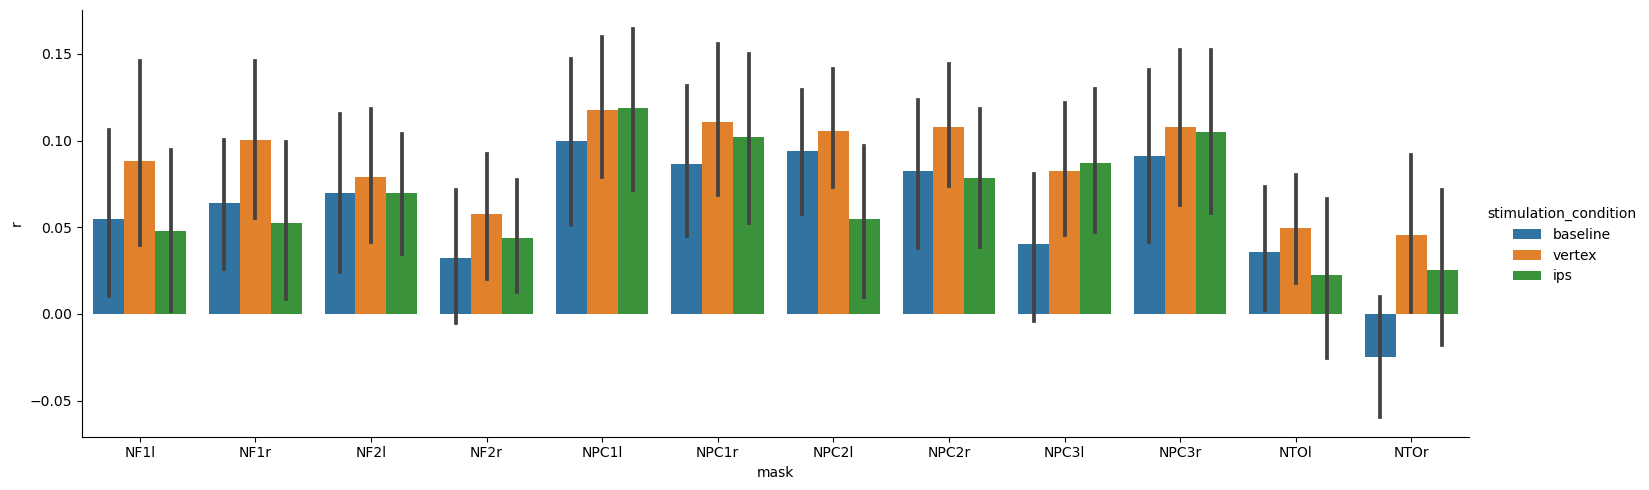

In [45]:
sns.catplot(x='mask', y='r', hue='stimulation_condition', data=r2.reset_index(), kind='bar', aspect=3.)

stimulation_condition                                 vertex       ips
subject pca    glm     smoothed     mask  n_voxels                    
1       no pca GLMstim not smoothed NF1l  1        -0.048457  0.076244
                                    NF1r  1        -0.064500 -0.102049
                                    NF2l  1         0.022710  0.111842
                                    NF2r  1         0.073933  0.068484
                                    NPC1l 1        -0.100284  0.178181
...                                                      ...       ...
74      no pca GLMstim not smoothed NPC2r 1         0.071207  0.058015
                                    NPC3l 1         0.148896 -0.074379
                                    NPC3r 1         0.245499  0.118568
                                    NTOl  1         0.092867 -0.070679
                                    NTOr  1         0.215037 -0.051036

[420 rows x 2 columns]

In [61]:
r2.droplevel('session').drop('baseline', level='stimulation_condition')['r'].unstack('stimulation_condition').groupby(['mask']).apply(lambda d: pingouin.ttest(d['ips'], d['vertex'], paired=True)).sort_values('p-val')

,,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
mask,,,,,,,,,
NPC2l,T-test,-2.767637,34,two-sided,0.009071,"[-0.09, -0.01]",0.414161,4.644,0.662981
NF1r,T-test,-1.757250,33,two-sided,0.088151,"[-0.1, 0.01]",0.333656,0.731,0.471698
NF1l,T-test,-1.388715,34,two-sided,0.173950,"[-0.1, 0.02]",0.262510,0.437,0.326358
NTOl,T-test,-1.207212,33,two-sided,0.235932,"[-0.09, 0.02]",0.270159,0.358,0.333679
NPC2r,T-test,-1.161636,34,two-sided,0.253474,"[-0.08, 0.02]",0.251968,0.337,0.304897
NTOr,T-test,-0.751071,34,two-sided,0.457777,"[-0.08, 0.03]",0.145036,0.236,0.132693
NPC1r,T-test,-0.562912,32,two-sided,0.577418,"[-0.07, 0.04]",0.112976,0.216,0.096521
NF2r,T-test,-0.453986,33,two-sided,0.652811,"[-0.06, 0.04]",0.105935,0.202,0.092141
NF2l,T-test,-0.337607,34,two-sided,0.737735,"[-0.07, 0.05]",0.084534,0.191,0.077484


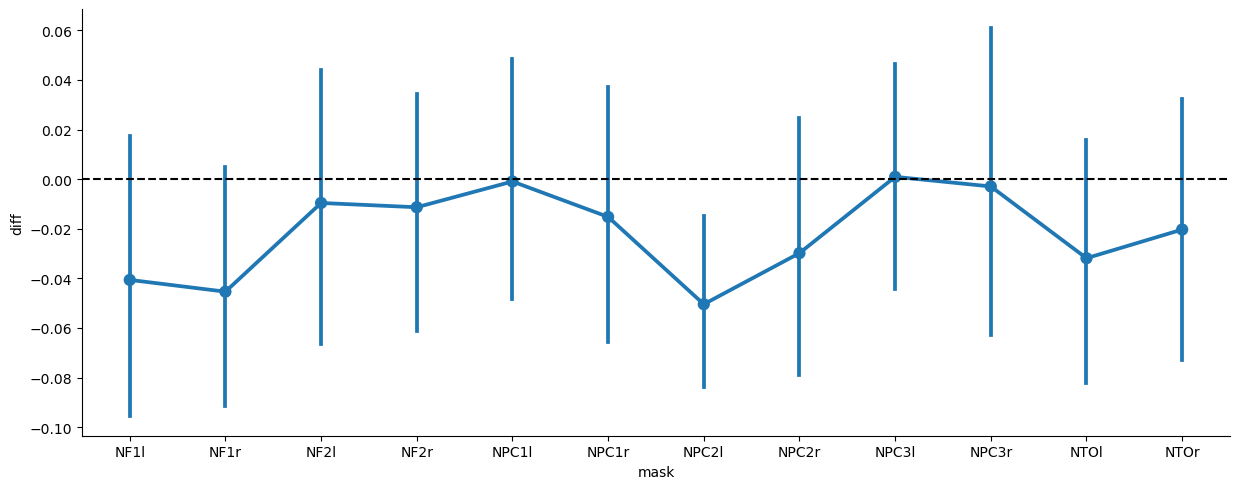

In [47]:
tmp = r2.droplevel('session').unstack(['stimulation_condition'])['r']

diff = (tmp['ips'] - tmp['vertex']).to_frame('diff')

sns.catplot(x='mask', y='diff', data=diff.reset_index(), kind='point', aspect=2.5)
plt.axhline(0.0, c='k', ls='--')

<Axes: xlabel='mask', ylabel='mask'>

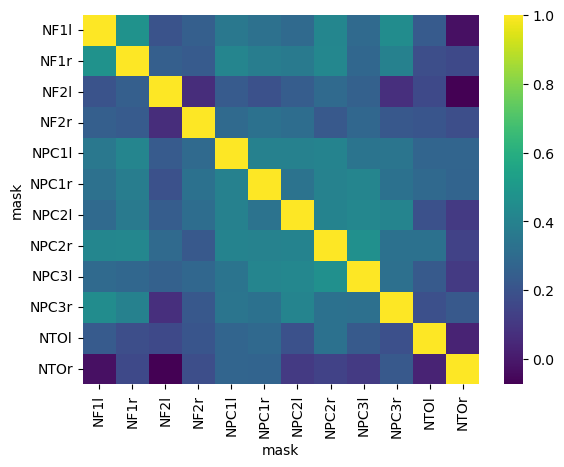

In [48]:
sns.heatmap(r2['r'].unstack('mask').corr(), cmap='viridis')

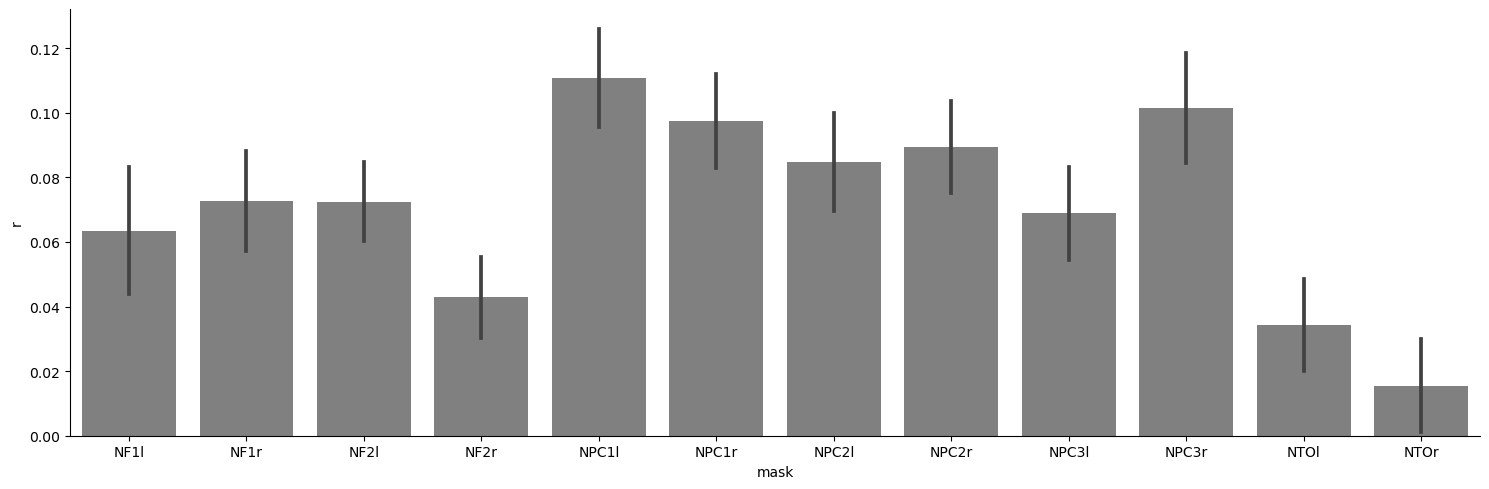

In [49]:
sns.catplot(x='mask', y='r', data=r2.groupby(['subject', 'mask']).mean().reset_index(), kind='bar', aspect=3., color='gray', errorbar='se')

In [50]:
r2.groupby(['subject', 'session', 'mask']).size().groupby(['mask', 'session']).size()

mask   session
NF1l   1          35
       2          35
       3          35
NF1r   1          35
       2          35
       3          34
NF2l   1          34
       2          35
       3          35
NF2r   1          34
       2          35
       3          34
NPC1l  1          35
       2          33
       3          35
NPC1r  1          35
       2          33
       3          35
NPC2l  1          35
       2          35
       3          35
NPC2r  1          35
       2          35
       3          35
NPC3l  1          35
       2          34
       3          35
NPC3r  1          35
       2          35
       3          35
NTOl   1          35
       2          35
       3          34
NTOr   1          35
       2          35
       3          35
dtype: int64